In [1]:
# Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from utilsforecast.plotting import plot_series as plot_series_utils
from fpppy.utils import plot_series
from statsmodels.graphics.tsaplots import plot_acf
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive
from mlforecast import MLForecast
from fpppy.models import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast.models import ARIMA
from statsforecast.models import AutoARIMA
from statsforecast.arima import ARIMASummary
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm

# Portfolio Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

# Load Data
energy_weather_day = pd.read_csv("../data/processed/energy_weather_daily.csv")
energy_weather_day['date'] = pd.to_datetime(energy_weather_day['date'])
energy_weather_day.set_index('date', inplace=True)

# Restore Weekday Order
energy_weather_day["weekday"] = pd.Categorical(
    energy_weather_day["weekday"], 
    categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    ordered=True
)


In [2]:
# Model Setup
train = energy_weather_day[energy_weather_day["year"] <= 2023].reset_index(drop=False)
test = energy_weather_day[energy_weather_day["year"] > 2023].reset_index(drop=False)

# Rename columns to match StatsForecast requirements (ds = date, y = target variable).
train = train.rename(columns={"date": "ds", "load_mwh": "y"})
train["unique_id"] = "id"

test = test.rename(columns={"date": "ds", "load_mwh": "y"})
test["unique_id"] = "id"

In [13]:
exog_train = pd.get_dummies(
    train[['month', 'is_holiday', 'TMK']], 
    columns=['month'], 
    prefix='month', 
    drop_first=True,
    dtype=float
)

exog_test = pd.get_dummies(
    test[['month', 'is_holiday', 'TMK']], 
    columns=['month'], 
    prefix='month', 
    drop_first=True,
    dtype=float
)

# SARIMAX
sarimax_model = SARIMAX(train['y'], exog=exog_train, order=(3,0,0), trend='ct', seasonal_order=(0,1,1,7),
                          enforce_stationarity=False, enforce_invertibility=False
                          ).fit(disp=False)



Out of sample Performance
                      Model           MAE  MAPE_%
0  SARIMAX(3,0,0)(0,1,1)[7]  78051.532404     6.1


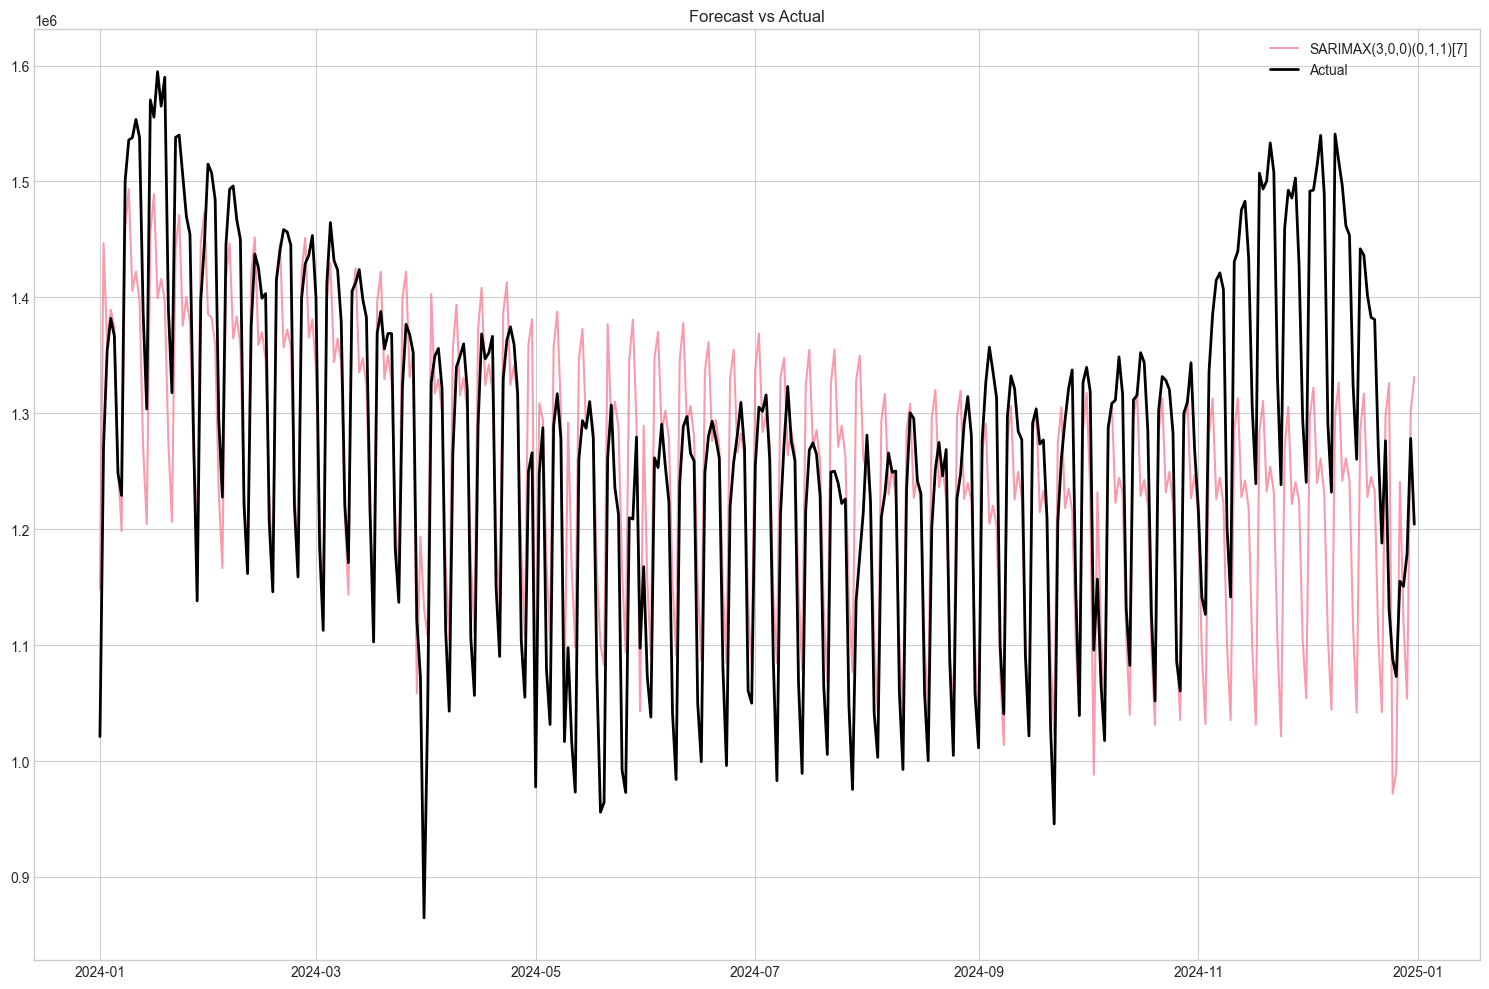

In [14]:
# Forecast
forecast_results = {}
forecast_results['SARIMAX(3,0,0)(0,1,1)[7]'] = sarimax_model.forecast(steps=len(test), exog=exog_test)

# Metrics
metrics = []
for model_name, forecast in forecast_results.items():
    mae = mean_absolute_error(test['y'], forecast)
    mape = mean_absolute_percentage_error(test['y'], forecast)
    metrics.append({
        'Model': model_name,
        'MAE': mae,
        'MAPE_%': round(mape * 100, 1)
    })

print("Out of sample Performance")
print(pd.DataFrame(metrics).sort_values('MAE'))

# Plot forecast
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(test['ds'], forecast_results['SARIMAX(3,0,0)(0,1,1)[7]'], label='SARIMAX(3,0,0)(0,1,1)[7]', alpha=0.7)
ax.plot(test['ds'], test['y'], 'k-', label='Actual', linewidth=2)
ax.set_title("Forecast vs Actual")
ax.legend()

fig.tight_layout()
plt.savefig('../images/09_Forecast.png', dpi=300, bbox_inches='tight')
fig.show()
